In [1]:
import os, sys, time, copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import multiprocessing
from functools import partial
from tqdm import tqdm

import collections
from typing import List

import myokit
sys.path.append('../')
sys.path.append('../Protocols')
sys.path.append('../Models')
sys.path.append('../Lib')
import protocol_lib
import mod_trace

import simulator_myokit
import simulator_scipy
import vc_protocols

In [2]:
# VC_protocol = vc_protocols.hERG_CiPA()
# VC_protocol = vc_protocols.cav12_CiPA()
# VC_protocol = vc_protocols.lateNav15_CiPA()

VC_protocol = protocol_lib.VoltageClampProtocol()  # steps=steps
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=100) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-90, duration=100) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=100) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-35, duration=40) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=200) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-40, duration=40) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=0, duration=40) )  # <- why?? vo
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=40, duration=500) )
VC_protocol.add( protocol_lib.VoltageClampRamp(voltage_start=40, voltage_end=-120, duration=200)) # ramp step
# VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=100) )
# VC_protocol.add( protocol_lib.VoltageClampStep(voltage=0, duration=100) )
# VC_protocol.add( protocol_lib.VoltageClampStep(voltage=60, duration=500) )
# VC_protocol.add( protocol_lib.VoltageClampRamp(voltage_start=60, voltage_end=-80, duration=200)) # ramp step

vhold = VC_protocol.steps[0].voltage

print(f'The protocol is {VC_protocol.get_voltage_change_endpoints()[-1]} ms')

The protocol is 1320 ms


In [3]:
gen_params = {
    'end_time': VC_protocol.get_voltage_change_endpoints()[-1],                            
    'log_li' : ['ina.INa', 'inal.INaL', 'ito.Ito', 'ical.ICaL', 'ical.ICaNa', 'ical.ICaK', 'ikr.IKr', 'iks.IKs', 'ik1.IK1', 'inaca.INaCa', 'inacass.INaCa_ss', 'inak.INaK', 'ikb.IKb', 'inab.INab', 'icab.ICab', 'ipca.IpCa'],
    'save_log_li' : ['ina.INa', 'ikr.IKr', 'iks.IKs', 'ito.Ito', 'ical.ICaL',  'ik1.IK1', 'inal.INaL'],
    'nData' : 5,                         
    'dataset_dir' : '../../Dataset/ohara2017_leemV1',
    'data_file_name' : 'currents',
    'window' : 10,
    'step_size' : 5,
}  
gen_params['dataset_dir'] = gen_params['dataset_dir'] + f"_w{gen_params['window']}_s{gen_params['step_size']}"
print( gen_params['dataset_dir'] )
cell_types = {
    'Endocardial' : 0,
    'Epicardial' : 1,
    'Mid-myocardial' : 2,
}
sys.path.append(gen_params['dataset_dir'])
from agetdata import get_dataset

../../Dataset/ohara2017_leemV1_w10_s5


In [4]:
gen_params['dataset_dir']

'../../Dataset/ohara2017_leemV1_w10_s5'

In [27]:
xs, ys = get_dataset(file_numbers=range(1,31), multi=False, use_torch=True)

--- 2.5625855922698975 seconds ---


In [28]:
print(xs.shape, ys.shape)

torch.Size([300000, 7, 263]) torch.Size([300000, 7])


In [29]:
dataNo = 0

x = xs[dataNo]
y = ys[dataNo]
sol1 = {}
sol1["I_Na"] = x[0]
sol1["I_NaL"] = x[1]
sol1["I_To"] = x[2]
sol1["I_CaL"] = x[3]
sol1["I_Kr"] = x[4]
sol1["I_Ks"] = x[5]
sol1["I_K1"] = x[6]


# sol1 = pd.DataFrame(data=sol1)
# sol1.head()

In [30]:
def find_closest_index(array, t):
    """Given an array, return the index with the value closest to t."""
    return (np.abs(np.array(array) - t)).argmin()

def get_currents_with_constant_dt(sol, window=1, step_size=1):
    
    times = sol['Time'].values
    currents = sol.drop(['Time'], axis=1)
    
    avg_currents = collections.defaultdict(list)
    t = 0
    while t <= times[-1] - window:
        start_index = find_closest_index(times, t)
        end_index = find_closest_index(times, t + window)
        currents_in_window = currents[start_index: end_index + 1]

        window_avg_currents = {}               
        for name in currents.columns:                 
            window_avg_currents[name] = currents_in_window[name].sum()/len(currents_in_window[name])    
            # window_avg_currents[name] = currents_in_window[name].min()
            # window_avg_currents[name] = currents_in_window[name].max()

        avg_currents['Time Start'].append(t)
        avg_currents['Time End'].append(t + window)
        avg_currents['Time Mid'].append((2*t + window)/2)

        for key, val in window_avg_currents.items():     
            # print(key, val)
            avg_currents[key].append(val)
        t += step_size
        
    return avg_currents

In [31]:
start_time = time.time()

model, p, s = myokit.load("../mmt-model-files/ohara-cipa-v1-2017_JK-v1.mmt")    
sim = simulator_myokit.Simulator(model, VC_protocol, max_step=1.0, abs_tol=1e-06, rel_tol=1e-6, vhold=vhold)  # 1e-12, 1e-14  # 1e-08, 1e-10
sim.name = "ohara2017"  

f = 1.5
params = {         
    'cell.mode': cell_types['Mid-myocardial'],
    'setting.simType': 1,   # 0: AP   |  1: VC  
    
    'ina.gNa' : 75.0 * f,   
    'inal.gNaL' : 0.0075 * 2.661 * f,  
    'ito.gto' : 0.02 * 4 * f,
    'ical.PCa' : 0.0001 * 1.007 * 2.5 * f,
    'ikr.gKr' : 4.65854545454545618e-2 * 1.3 * f, # [mS/uF]
    'iks.gKs' : 0.0034 * 1.87 * 1.4 * f,
    'ik1.gK1' : 0.1908 * 1.698 * 1.3 * f,
    'inaca.gNaCa' : 0.0008 * 1.4,
    'inak.PNaK' : 30 * 0.7,
    'ikb.gKb' : 0.003,
    'inab.PNab' : 3.75e-10,
    'icab.PCab' : 2.5e-8,
    'ipca.GpCa' : 0.0005,
}
sim.set_simulation_params(params)

print("--- %s seconds ---"%(time.time()-start_time))

--- 5.383224248886108 seconds ---


In [32]:
start_time = time.time()

g_adj_li= {
    'ina.g_adj' : y[0],
    'ikr.g_adj' : y[1],
    'iks.g_adj' : y[2],
    'ito.g_adj' : y[3],
    'ical.g_adj' : y[4],
    'ik1.g_adj' : y[5],
    'inal.g_adj' : y[6],
                # 'if.g_adj' : g_fc[7]    
} 
sim.set_simulation_params(g_adj_li)  

sim.pre_simulate(5000, sim_type=1)
d = sim.simulate( gen_params['end_time'], extra_log=['membrane.VC', 'membrane.i_ion']+gen_params['log_li'])                           

sol2 = {}
sol2["Time"] = d['engine.time']
# sol2["Voltage"] = d['membrane.VC']
# sol2["I_total"] = d['membrane.i_ion']
sol2["I_Na"] = sim.current_response_info.get_current(['INa'])
sol2["I_NaL"] = sim.current_response_info.get_current(['INaL'])
sol2["I_To"] = sim.current_response_info.get_current(['Ito'])
sol2["I_CaL"] = sim.current_response_info.get_current(['ICaL'])
sol2["I_Kr"] = sim.current_response_info.get_current(['IKr'])
sol2["I_Ks"] = sim.current_response_info.get_current(['IKs'])
sol2["I_K1"] = sim.current_response_info.get_current(['IK1'])
sol2 = pd.DataFrame(data=sol2)
sol2.head()

print("--- %s seconds ---"%(time.time()-start_time))

--- 0.20254898071289062 seconds ---


In [33]:
sol2

,Time,I_Na,I_NaL,I_To,I_CaL,I_Kr,I_Ks,I_K1
0,0.000000,-1.152058e-02,-1.075507e-03,0.001562,-4.178198e-06,0.000526,-6.279068e-07,2.533577
1,0.003432,-1.152058e-02,-1.075507e-03,0.001562,-4.178198e-06,0.000526,-6.279059e-07,2.533577
2,1.003432,-1.152058e-02,-1.075508e-03,0.001562,-4.178198e-06,0.000526,-6.276200e-07,2.533568
3,2.003432,-1.152059e-02,-1.075510e-03,0.001562,-4.178198e-06,0.000526,-6.273341e-07,2.533559
4,3.003432,-1.152059e-02,-1.075512e-03,0.001562,-4.178198e-06,0.000526,-6.270484e-07,2.533550
...,...,...,...,...,...,...,...,...
2075,1319.999757,-4.962087e-07,-4.529948e-07,-0.000396,-4.727798e-10,-0.167386,-6.907531e-03,-44.274269
2076,1319.999947,-4.961866e-07,-4.529732e-07,-0.000396,-4.727634e-10,-0.167384,-6.907412e-03,-44.274503
2077,1319.999991,-4.961816e-07,-4.529694e-07,-0.000396,-4.727597e-10,-0.167384,-6.907385e-03,-44.274556
2078,1319.999998,-4.961809e-07,-4.529688e-07,-0.000396,-4.727591e-10,-0.167384,-6.907381e-03,-44.274564


In [34]:
sol2 = get_currents_with_constant_dt(sol2, window=gen_params['window'], step_size=gen_params['step_size'])

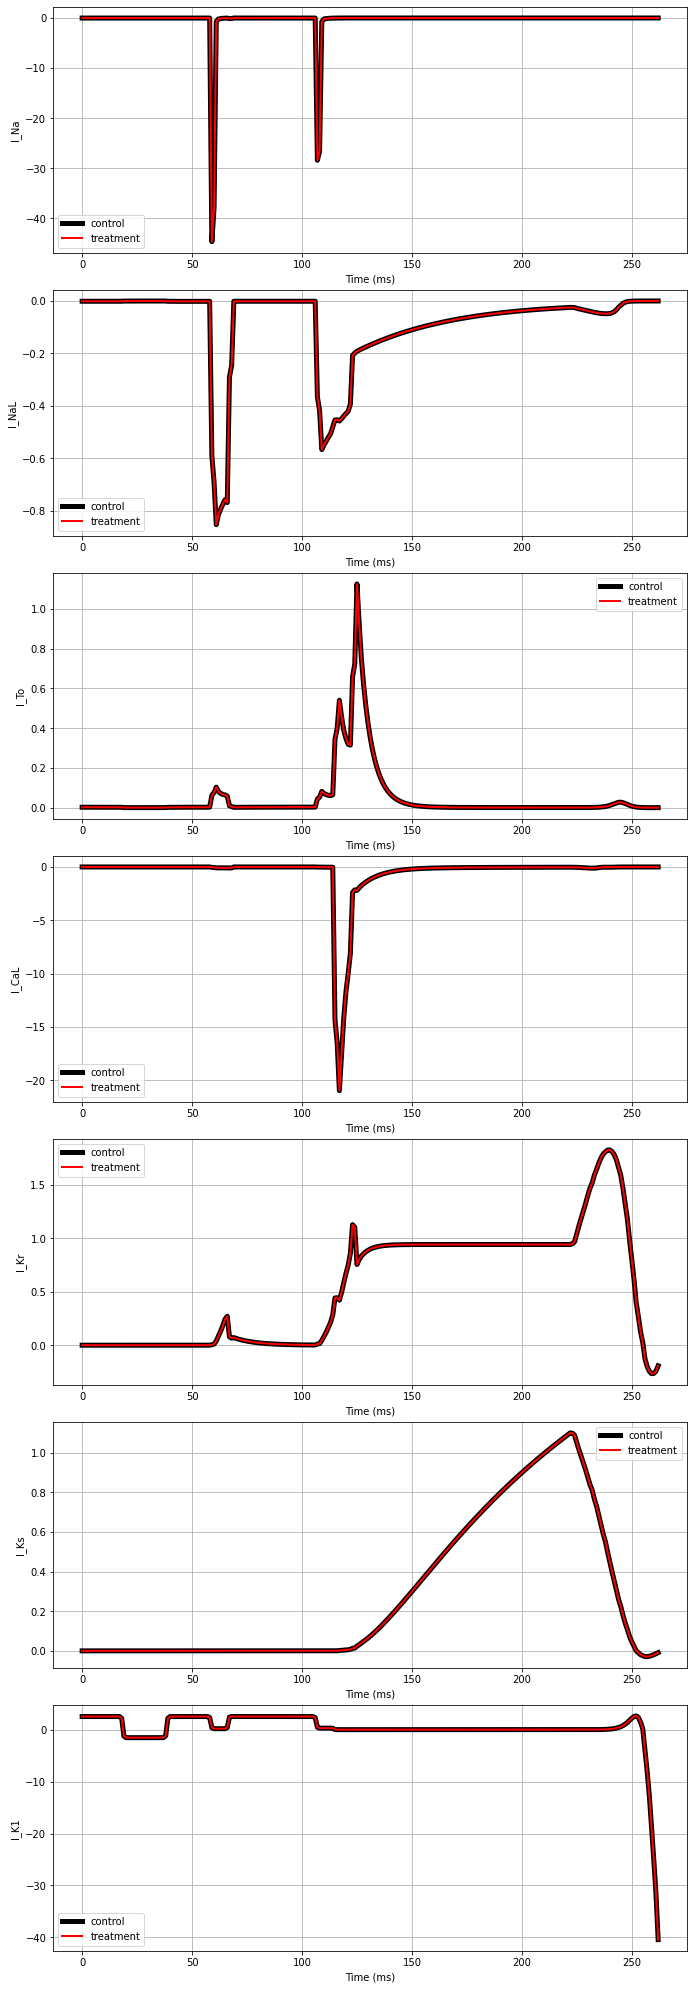

In [35]:
'''
Plot
'''
fig, ax = plt.subplots(7,1, figsize=(10,30))    
# fig.suptitle(sim.name, fontsize=14)
axNo = 0
for name, value in sol1.items():    
    if name!='Time Start' and name!='Time End' and name!='Time Mid':
        # ax.set_title('Simulation %d'%(simulationNo))
        # axes[i].set_xlim(model_scipy.times.min(), model_scipy.times.max())
        # ax.set_ylim(ylim[0], ylim[1])
        ax[axNo].set_xlabel('Time (ms)')       
        ax[axNo].set_ylabel(f'{name}')      
        ax[axNo].plot( value, label='control', color='k', linewidth=5)     
        ax[axNo].plot( sol2[name], label='treatment', color='r', linewidth=2)    
        ax[axNo].legend()
        ax[axNo].grid()
        axNo += 1

# ax[-1].set_ylim(-5, 5)

plt.subplots_adjust(left=0.07, bottom=0.05, right=0.95, top=0.95, wspace=0.5, hspace=0.15)
plt.show()
# fig.savefig(os.path.join('Results', "C.jpg"), dpi=100)